## Dogs v Cats

In [148]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
import skimage
import skimage.transform

In [166]:
PATH = "/fastai/data/dogscats"
sz = 224
arch = resnet34
bs  = 64

In [167]:
m = arch(True)

In [168]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

create model with all children but last 2 and add our own 2 layers

In [169]:
m = nn.Sequential(*children(m)[:-2],
                  nn.Conv2d(512,2,3,padding=1),
                  nn.AdaptiveAvgPool2d(1), Flatten(),
                  nn.LogSoftmax())

In [170]:
tfms =  tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data =  ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [171]:
learn = ConvLearner.from_model_data(m, data)

In [172]:
learn.freeze_to(-4) # freeze all but last 4 layers for training

In [173]:
m[-1].trainable # check trainable should be True only for last four layers

True

In [174]:
m[-4].trainable

True

In [175]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.13791    0.163234   0.9815    



[0.1632339781820774, 0.9815]

In [19]:
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.066002   0.062724   0.988     



[0.06272414326667786, 0.988]

## Class Activation Maps (CAM)

In [196]:
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output): self.features = output
    def remove(self): self.hook.remove()

In [252]:
x,y = next(iter(data.trn_dl))

In [239]:
#x,y =  x[None,1], y[None,1] 

In [240]:
#vx = Variable(x.cuda(), requires_grad=True)

In [253]:
x.shape,y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

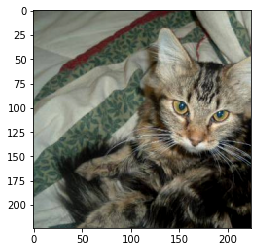

In [281]:
dx =  data.trn_ds.denorm(x)[33]
plt.imshow(dx)

In [282]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [283]:
%time py = m(Variable(x.cuda()))

CPU times: user 1.19 ms, sys: 4.87 ms, total: 6.05 ms
Wall time: 5.22 ms


In [284]:
for o in sfs: o.remove()

In [285]:
[o.features.size() for o in sfs]

[torch.Size([64, 128, 28, 28]),
 torch.Size([64, 256, 14, 14]),
 torch.Size([64, 512, 7, 7]),
 torch.Size([64, 2, 7, 7])]

In [286]:
py = np.exp(to_np(py)[33]); py

array([1., 0.], dtype=float32)

In [287]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [288]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


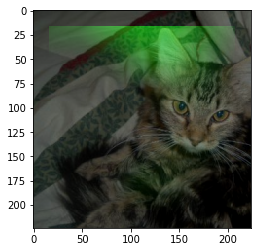

In [289]:
plt.imshow(dx)
plt.imshow(skimage.transform.resize(f2,dx.shape),alpha=0.5, cmap='hot')

## Model

In [67]:
learn.unfreeze()
learn.bn_freeze(True)

In [68]:
lr =np.array([[1e-6]*4, [1e-4]*4, [1e-2]*4]).flatten()

In [69]:
lr

array([0.    , 0.    , 0.    , 0.    , 0.0001, 0.0001, 0.0001, 0.0001, 0.01  , 0.01  , 0.01  , 0.01  ])

In [70]:
learn.fit(lr,2,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.040953   0.035282   0.9915    
    1      0.029621   0.043325   0.9905                       



[0.043325107097625735, 0.9905]

In [72]:
log_preds,y =  learn.TTA()
preds = np.mean(np.exp(log_preds), 0)
accuracy_np(preds,y)

0.991

In [73]:
learn.fit(lr,2,cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.0244     0.034403   0.99      
    1      0.024706   0.030988   0.99                         



[0.030987985879182816, 0.99]

In [74]:
log_preds,y = learn.TTA()
preds =  np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

0.9915